---

# Resample data to achieve more consistent training series
- assuming that data has been organized into folders as ./base/xxxxx_class/imgxxx.jpg
---

In [1]:
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import shutil as sh


In [18]:
def mean(vec):
    return sum(vec)/len(vec) if len(vec) != 0 else None

In [3]:
"""def resample(X, y, sample_type=None, sample_size=None, class_weights=None, seed=None):

    # Nothing to do if sample_type is 'abs' or not set.  sample_size should then be int
    # If sample type is 'min' or 'max' then sample_size should be float
    if sample_type == 'min':
        sample_size_ = np.round(sample_size * y.value_counts().min()).astype(int)
    elif sample_type == 'max':
        sample_size_ = np.round(sample_size * y.value_counts().max()).astype(int)
    else:
        sample_size_ = max(int(sample_size), 1)

    if seed is not None:
        np.random.seed(seed)

    if class_weights is None:
        class_weights = dict()

    X_resampled = pd.DataFrame()

    for yi in y.unique():
        size = np.round(sample_size_ * class_weights.get(yi, 1.)).astype(int)

        X_yi = X[y == yi]
        sample_index = np.random.choice(X_yi.index, size=size)
        X_resampled = X_resampled.append(X_yi.reindex(sample_index))

    return X_resampled
"""

"def resample(X, y, sample_type=None, sample_size=None, class_weights=None, seed=None):\n\n    # Nothing to do if sample_type is 'abs' or not set.  sample_size should then be int\n    # If sample type is 'min' or 'max' then sample_size should be float\n    if sample_type == 'min':\n        sample_size_ = np.round(sample_size * y.value_counts().min()).astype(int)\n    elif sample_type == 'max':\n        sample_size_ = np.round(sample_size * y.value_counts().max()).astype(int)\n    else:\n        sample_size_ = max(int(sample_size), 1)\n\n    if seed is not None:\n        np.random.seed(seed)\n\n    if class_weights is None:\n        class_weights = dict()\n\n    X_resampled = pd.DataFrame()\n\n    for yi in y.unique():\n        size = np.round(sample_size_ * class_weights.get(yi, 1.)).astype(int)\n\n        X_yi = X[y == yi]\n        sample_index = np.random.choice(X_yi.index, size=size)\n        X_resampled = X_resampled.append(X_yi.reindex(sample_index))\n\n    return X_resampled\n"

---

In [10]:
#sourceDir = '../dataCropSQ/Img/'
sourceDir = '../data/Img/'
#trainTargetDir = '../dataCropSQRS/train/upper'
#testTargetDir = '../dataCropSQRS/test/upper'
#sourceDir = '/Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/dataCropSQ/Img/'
#trainTargetDir = '/Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/fdata_CropSQRS/train'
#testTargetDir = '/Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/fdata_CropSQRS/test'

In [11]:
with open('../data/Anno/list_category_cloth.txt','r') as fp:
    lines = [ l.rstrip().replace('1','upper') \
                        .replace('2','lower') \
                        .replace('3','full').split() for l in fp][2:]  
    mainCatagories = { l[0]:l[1] for l in lines}

In [12]:
classDict = {}
for d,_,files in os.walk(sourceDir,topdown=False):
    cl_name = d.split('_')[-1]
    if mainCatagories.get(cl_name) is None: continue
    if classDict.get(cl_name) is None: classDict[cl_name] = []
    classDict[cl_name].extend([ d + '/' + f for f in files \
                                   if not f.startswith('.') or not f.endswith('.jpg') ])

# clean out some old classes which were ignored
bunkKeys = []
for cl_name in mainCatagories.keys():
    if classDict.get(cl_name) is None: bunkKeys.append(cl_name)
        
# can't do it in one step, because you're modifing the object you're working on
for b in bunkKeys:
    mainCatagories.pop(b,None)

In [13]:
classCount = { k:len(v) for k,v in classDict.items()}
print('Total image files',sum([v for v in classCount.values()]))
print('UpperClass:',sum([classCount[cl] for cl,ca in mainCatagories.items() if ca == 'upper' ]))
print('LowerClass:',sum([classCount[cl] for cl,ca in mainCatagories.items() if ca == 'lower' ]))
print('FullClass:',sum([classCount[cl] for cl,ca in mainCatagories.items() if ca == 'full' ]))

Total image files 289219
UpperClass: 139716
LowerClass: 58963
FullClass: 90540


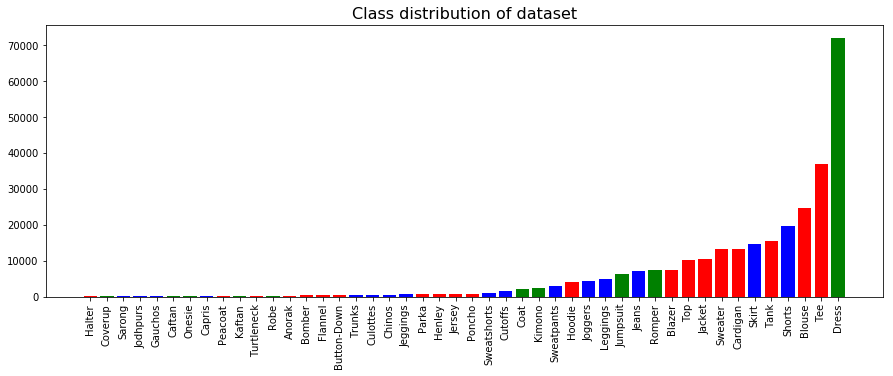

In [14]:
names = sorted(classCount.items(),key=lambda kv: kv[1])
namesSorted = [ v[0] for v in names]
valuesSorted = [ v[1] for v in names]
labelsSorted = [ mainCatagories[n] for n in namesSorted]
colorSorted = []
for n in namesSorted:
    color =      'red'  if mainCatagories[n] == 'upper' \
            else 'blue' if mainCatagories[n] == 'lower' \
            else 'green'
    colorSorted.append(color)

plt.figure(figsize=(15,5))
plt.bar(range(len(valuesSorted)),valuesSorted,color=colorSorted)
plt.xticks(range(len(valuesSorted)),namesSorted,rotation='vertical')
plt.title('Class distribution of dataset',fontsize=16)
plt.show()

In [22]:
def plotClassCount(clCountDict,title='',color='blue'):
    names = sorted(clCountDict.items(),key=lambda kv: kv[1])
    namesSorted = [ v[0] for v in names]
    valuesSorted = [ v[1] for v in names]
    plt.bar(range(len(valuesSorted)),valuesSorted,color=color)
    plt.xticks(range(len(valuesSorted)),namesSorted,rotation='vertical')
    plt.grid(color='grey',axis='y',linestyle='--', linewidth=0.5)
    plt.title(title,fontsize=16,fontweight='bold')
    plt.show()
    
def summarizeClassCount(clCountDict):
    print(' min=',min(clCountDict.values()))
    print(' avg=',mean(clCountDict.values()))
    print(' max=',max(clCountDict.values()))

In [20]:
catagories = ['upper','lower','full']
ctClDict = { ct:{ k:v for k,v in classDict.items() if mainCatagories[k] == ct} for ct in catagories }
ctClCount = { ct:{ k:len(v) for k,v in ctClDict[ct].items()} for ct in catagories }

In [21]:
print('Summary:  Upper Class')
summarizeClassCount(ctClCount['upper'])

Summary:  Upper Class
 min= 17
 avg= 6985.8
 max= 36887


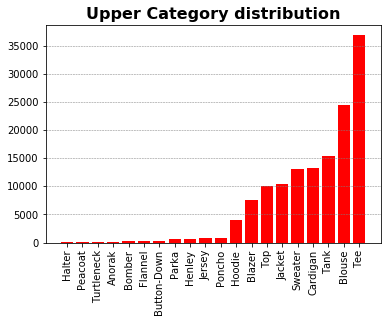

In [25]:
plotClassCount(ctClCount['upper'],title='Upper Category distribution',color='red')

In [27]:
print('Summary:  Lower Class')
summarizeClassCount(ctClCount['lower'])

Summary:  Lower Class
 min= 32
 avg= 3685.1875
 max= 19666


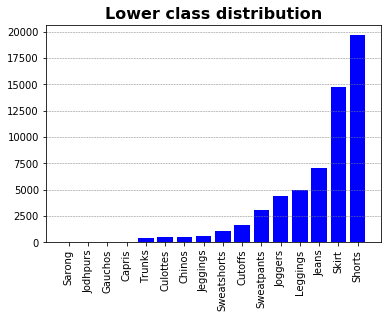

In [28]:
plotClassCount(ctClCount['lower'],title='Lower class distribution',color='blue')

In [29]:
ctClCount['lower']['Sweatpants']

3048

In [30]:
print('Summary: Full Class')
summarizeClassCount(ctClCount['full'])

Summary: Full Class
 min= 17
 avg= 9054.0
 max= 72148


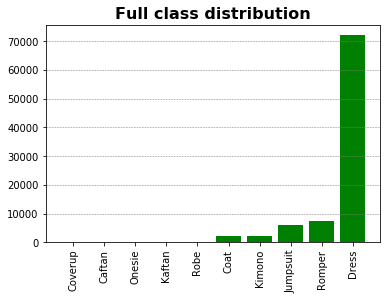

In [31]:
plotClassCount(ctClCount['full'],title='Full class distribution',color='green')

In [32]:
print('Robe=',ctClCount['full']['Robe'])
print('Coat=',ctClCount['full']['Coat'])

Robe= 150
Coat= 2120


In [33]:
threshhold = 2000
selectedClasses = {ct:[k for k,v in ctClCount[ct].items() if v >= threshhold] for ct in catagories}


In [34]:
selectedClasses

{'upper': ['Tank',
  'Jacket',
  'Blouse',
  'Top',
  'Tee',
  'Sweater',
  'Blazer',
  'Cardigan',
  'Hoodie'],
 'lower': ['Sweatpants', 'Shorts', 'Jeans', 'Joggers', 'Skirt', 'Leggings'],
 'full': ['Dress', 'Romper', 'Kimono', 'Jumpsuit', 'Coat']}

In [35]:
testSplit = 0.15
trainClDict = {}
testClDict = {}
for ct,cls in selectedClasses.items():
    trainClDict[ct] = {}
    testClDict[ct] = {}
    for cl in cls:
        trainClDict[ct][cl], testClDict[ct][cl] = train_test_split(ctClDict[ct][cl],test_size = testSplit)

In [36]:
print('train[Hoodie]=',len(trainClDict['upper']['Hoodie']))
print(' test[Hoodie]=',len(testClDict['upper']['Hoodie']))
print(' percentage Check=',len(testClDict['upper']['Hoodie'])/len(trainClDict['upper']['Hoodie']))

train[Hoodie]= 3440
 test[Hoodie]= 608
 percentage Check= 0.17674418604651163


In [42]:
trainClDictRS = {}
testClDictRS = {}
nsamples = 5000
nsamples_t = int(nsamples*testSplit)

for ct in trainClDict.keys():
    trainClDictRS[ct] = {}
    testClDictRS[ct] = {}
    for cl in trainClDict[ct].keys():
        useReplace_train = not len(trainClDict[ct][cl]) > nsamples
        useReplace_test = not len(testClDict[ct][cl]) > nsamples_t
        trainClDictRS[ct][cl] = resample(trainClDict[ct][cl],n_samples=nsamples,replace=useReplace_train)
        testClDictRS[ct][cl] = resample(testClDict[ct][cl],n_samples=nsamples_t,replace=useReplace_test)

In [43]:
len(trainClDictRS['upper']['Hoodie'])

5000

In [44]:
len(testClDictRS['upper']['Hoodie'])

750

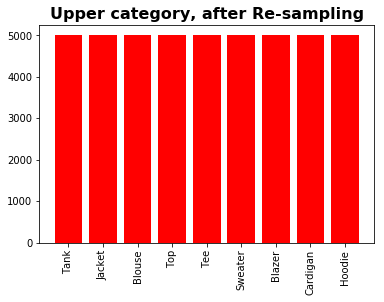

In [45]:
plt.bar(range(len(list(trainClDictRS['upper'].keys()))),
        [len(v) for k,v in trainClDictRS['upper'].items()],
        color='red')
plt.xticks(range(len(list(trainClDictRS['upper'].keys()))), trainClDictRS['upper'].keys(),rotation='vertical')
plt.title('Upper category, after Re-sampling', fontsize=16, fontweight='bold')
plt.show()

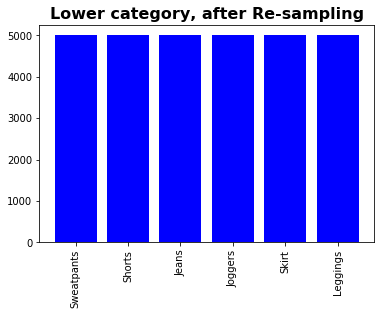

In [46]:
plt.bar(range(len(list(trainClDictRS['lower'].keys()))),
        [len(v) for k,v in trainClDictRS['lower'].items()],
        color='blue')
plt.xticks(range(len(list(trainClDictRS['lower'].keys()))), trainClDictRS['lower'].keys(),rotation='vertical')
plt.title('Lower category, after Re-sampling', fontsize=16, fontweight='bold')
plt.show()

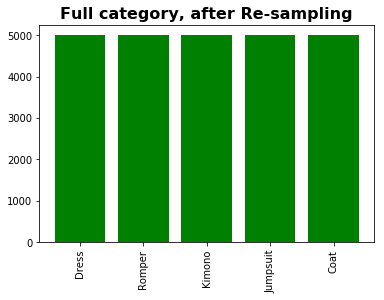

In [47]:
plt.bar(range(len(list(trainClDictRS['full'].keys()))),
        [len(v) for k,v in trainClDictRS['full'].items()],
        color='green')
plt.xticks(range(len(list(trainClDictRS['full'].keys()))), trainClDictRS['full'].keys(),rotation='vertical')
plt.title('Full category, after Re-sampling', fontsize=16, fontweight='bold')
plt.show()

---
# Copy files to new training directory
- resampling of redundant files will be handled by the augmenter
---

In [131]:
def copyAndRenameFile(sourceFile,classTargetDir):
    # if file exists, renames the file to unique name
    labelDir,imgFileOrig = sourceFile.split('/')[-2:]
    fullTargetDir = os.path.join(classTargetDir,labelDir)
    if not os.path.exists(fullTargetDir): os.mkdir(fullTargetDir)
        
    ind = 0
    imgFile = imgFileOrig
    #print(imgFile)
    while os.path.exists(os.path.join(fullTargetDir,imgFile)):
        name,ext = imgFileOrig.split('.')
        imgFile = name + f"R{ind:03d}." + ext
        ind += 1
    
    sh.copy(sourceFile,fullTargetDir + '/' + imgFile)

In [102]:
print('sourceDir=',sourceDir)
assert os.path.exists(sourceDir),'Failed to find sourceDir'
print('trainTargetDir=',trainTargetDir)
assert os.path.exists(trainTargetDir),'Failed to find trainTargetDir'
print('testTargetDir=',testTargetDir)
assert os.path.exists(testTargetDir),'Failed to find testTargetDir'

sourceDir= /Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/dataCropSQ/Img/
trainTargetDir= /Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/fdata_CropSQRS/train
testTargetDir= /Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/fdata_CropSQRS/test


In [142]:
for ct,cls in trainClDictRS.items():
    ctDir = os.path.join(trainTargetDir,ct)
    if not os.path.exists(ctDir): os.mkdir(ctDir)
    for cl,files in cls.items():
        clDir = os.path.join(ctDir,cl)
        if not os.path.exists(clDir): os.mkdir(clDir)
        for f in files:
            copyAndRenameFile(f,clDir)
            break  # remove

img_00000049.jpg
img_00000042.jpg
img_00000082.jpg
img_00000015.jpg
img_00000005.jpg
img_00000021.jpg
img_00000001.jpg
img_00000049.jpg
img_00000141.jpg
img_00000074.jpg
img_00000013.jpg
img_00000037.jpg
img_00000031.jpg
img_00000023.jpg
img_00000007.jpg
img_00000017.jpg
img_00000015.jpg
img_00000054.jpg
img_00000011.jpg
img_00000061.jpg


# Visualize the validation class distribution

In [ ]:
valDir = '../fashion_data_class/val/''
